In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import time
import sklearn
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for model in mpl, np, pd, sklearn, keras:
    print(model.__name__, model.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.0
pandas 1.0.5
sklearn 0.23.1
tensorflow_core.keras 2.2.4-tf


In [2]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

# pandas读取csv
train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)
print(train_df.head())
print(eval_df.head())


   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [3]:
# pop()
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [4]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [35]:
print(train_df.shape, eval_df.shape)
print(train_df.shape[0])
print(eval_df.shape[0])

(627, 9) (264, 9)
627
264


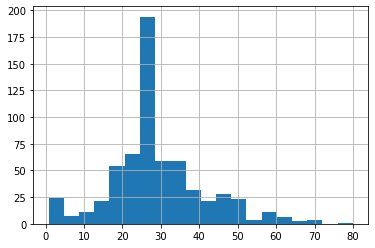

In [6]:
train_df.age.hist(bins = 20)

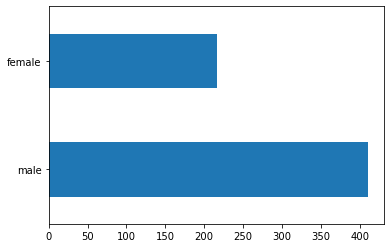

In [7]:
train_df.sex.value_counts().plot(kind = 'barh') # barv

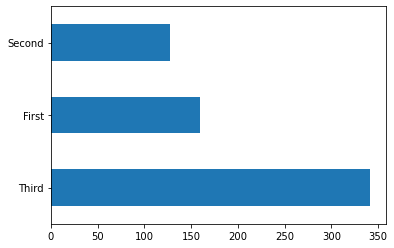

In [8]:
train_df['class'].value_counts().plot(kind = 'barh') #train_df.class函数关键字冲突

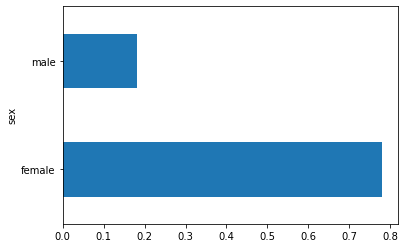

In [9]:
pd.concat([train_df,y_train], axis = 1).groupby('sex').survived.mean().plot(kind = 'barh')

In [10]:
# feature_column
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class','deck', 'embark_town', 'alone'] # 离散列
numeric_columns = ['age', 'fare'] # 连续列

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column,vocab)
    # indicator_column 独热编码
    # categorical_column_with_vocabulary_list 离散
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(categorical_column, vocab)))
    
# numeric_column 数值    
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(numeric_column,dtype=tf.float64))
    


sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [26]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size =32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset



In [27]:
train_dataset = make_dataset(train_df,y_train,batch_size = 5)
for x,y in train_dataset.take(1):
    print(x,y)

{'sex': <tf.Tensor: id=11685, shape=(5,), dtype=string, numpy=array([b'male', b'female', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: id=11677, shape=(5,), dtype=float64, numpy=array([65., 42., 45., 66., 28.])>, 'n_siblings_spouses': <tf.Tensor: id=11683, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0])>, 'parch': <tf.Tensor: id=11684, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0])>, 'fare': <tf.Tensor: id=11682, shape=(5,), dtype=float64, numpy=array([ 26.55  , 227.525 ,   8.05  ,  10.5   ,  13.8625])>, 'class': <tf.Tensor: id=11679, shape=(5,), dtype=string, numpy=array([b'First', b'First', b'Third', b'Second', b'Second'], dtype=object)>, 'deck': <tf.Tensor: id=11680, shape=(5,), dtype=string, numpy=array([b'E', b'unknown', b'unknown', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: id=11681, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Cherbourg', b'Southampton', b'Southampton',
       b'Cherbourg'], dtype=object)>, 'alo

In [28]:
# keras.layers.DenseFeatures
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[19.]
 [14.]
 [28.]
 [23.]
 [30.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [29]:
# keras.layers.DenseFeatures
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 3.      1.      0.      0.      0.      1.      1.      0.      0.
   0.      0.      0.      0.      0.      0.      1.      0.      0.
  41.5792  1.      0.      0.      0.      0.      0.      0.      0.
   0.      1.      0.      0.      0.      0.      1.    ]
 [24.      1.      0.      0.      0.      1.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  65.      1.      0.      0.      0.      0.      0.      0.      0.
   0.      1.      0.      0.

In [30]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01), 
              metrics =['accuracy'])

In [33]:
# 1. model.fit
# 2. model -> estimator -> train

train_dataset = make_dataset(train_df,y_train,epochs = 100)
eval_dataset = make_dataset(eval_df,y_eval,epochs=1,shuffle = False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 627//32,  # total/batch_size
                    validation_steps = 264//32, 
                    epochs = 100)

Train for 19 steps, validate for 8 steps
Epoch 1/100
19/19 [==============================] - 7s 390ms/step - loss: 0.5073 - accuracy: 0.7632 - val_loss: 0.5079 - val_accuracy: 0.7344
Epoch 2/100
19/19 [==============================] - 1s 42ms/step - loss: 0.5198 - accuracy: 0.7516 - val_loss: 0.5027 - val_accuracy: 0.7461
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.76 - 0s 19ms/step - loss: 0.4983 - accuracy: 0.7632 - val_loss: 0.4967 - val_accuracy: 0.7500
Epoch 4/100
19/19 [==============================] - 0s 18ms/step - loss: 0.5014 - accuracy: 0.7615 - val_loss: 0.4834 - val_accuracy: 0.7539
Epoch 5/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5295 - accuracy: 0.7368 - val_loss: 0.5126 - val_accuracy: 0.7383
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.5097 - accuracy: 0.7516 - val_loss: 0.4983 - val_accuracy: 0.7383
Epoch 7/100
19/19 [==============================] - 0s 7ms/step 

Epoch 58/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4508 - accuracy: 0.8059 - val_loss: 0.5214 - val_accuracy: 0.7344
Epoch 59/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4759 - accuracy: 0.7845 - val_loss: 0.5182 - val_accuracy: 0.7539
Epoch 60/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4633 - accuracy: 0.7911 - val_loss: 0.5810 - val_accuracy: 0.6602
Epoch 61/100
19/19 [==============================] - 0s 4ms/step - loss: 0.4895 - accuracy: 0.7796 - val_loss: 0.4836 - val_accuracy: 0.7461
Epoch 62/100
19/19 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 0.7977 - val_loss: 0.4835 - val_accuracy: 0.7539
Epoch 63/100
19/19 [==============================] - 0s 5ms/step - loss: 0.4560 - accuracy: 0.7944 - val_loss: 0.4823 - val_accuracy: 0.7578
Epoch 64/100
19/19 [==============================] - 0s 5ms/step - loss: 0.4837 - accuracy: 0.7697 - val_loss: 0.5852 - val_accuracy: 0.7148
Epoch 

In [47]:
# keras.estimator.model_to_estimator
estimator = keras.estimator.model_to_estimator(model)
#estimator = tf.compat.v1.keras.estimator.model_to_estimator(model)
# 1. function
# 2. return  a. (features, labels)   b. dataset -> (feature,label)

estimator.train(input_fn = lambda : make_dataset(train_df,y_train,epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ADMINI~1\\AppData\\Local\\Temp\\tmp1y13c35x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000027AE5148>, '_task_type': 'worker', '_task_id': 0, '_gl

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.